Mounted at /content/drive
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 561ms/step - loss: 0.6326 - mean_io_u: 0.3578 - val_loss: 0.5114 - val_mean_io_u: 0.3713
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.5218 - mean_io_u: 0.3618 - val_loss: 0.4400 - val_mean_io_u: 0.3713
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.3990 - mean_io_u: 0.3613 - val_loss: 0.2994 - val_mean_io_u: 0.3713
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.3160 - mean_io_u: 0.3675 - val_loss: 0.2695 - val_mean_io_u: 0.3713
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - loss: 0.3017 - mean_io_u: 0.3598 - val_loss: 0.2523 - val_mean_io_u: 0.3720
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.2380 - mean_io_u: 0.3714 - val_loss: 0.2307 - val_mean_io_u: 0.3723
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.2403 - mean_io_u: 0.3673 - val_loss: 0.2108 - val_mean_io_u: 0.3875
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0

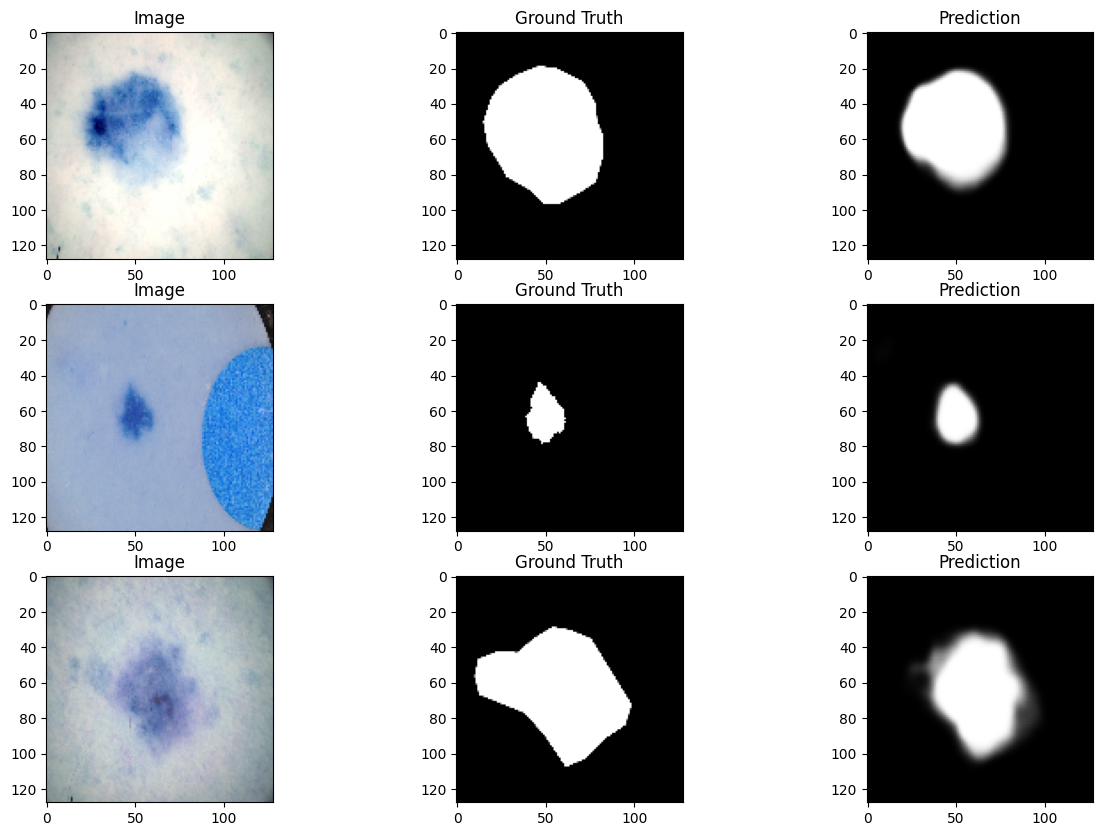

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.mixed_precision import Policy
from google.colab import drive
import cv2

# Enable Mixed Precision
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
base_dir = '/content/drive/MyDrive/health_care_project/extracted_files'
train_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_Data')
train_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_GroundTruth')
test_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_Data')
test_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_GroundTruth')

# Load images and masks
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
    return np.array(images)

train_images = load_images_from_folder(train_images_dir)
train_masks = load_images_from_folder(train_masks_dir)
test_images = load_images_from_folder(test_images_dir)
test_masks = load_images_from_folder(test_masks_dir)

# Preprocess data
train_images = train_images / 255.0
train_masks = train_masks / 255.0
train_masks = np.expand_dims(train_masks[:, :, :, 0], axis=3)  # single-channel masks
test_images = test_images / 255.0
test_masks = test_masks / 255.0
test_masks = np.expand_dims(test_masks[:, :, :, 0], axis=3)  # single-channel masks

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)




# Define U-Net model
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u6 = layers.concatenate([u6, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

# Training the model
checkpoint = ModelCheckpoint('/content/drive/MyDrive/health_care_project/unet_model.keras', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, callbacks=[checkpoint])


# Evaluate the model
test_loss, test_miou = model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}')
print(f'Test Mean IoU: {test_miou}')

# Visualize predictions
def display_predictions(images, masks, model, num_images=3):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(0, images.shape[0])
        image = images[idx]
        mask = masks[idx]
        prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]

        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth')

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(prediction, cmap='gray')
        plt.title('Prediction')
    plt.show()

display_predictions(test_images, test_masks, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


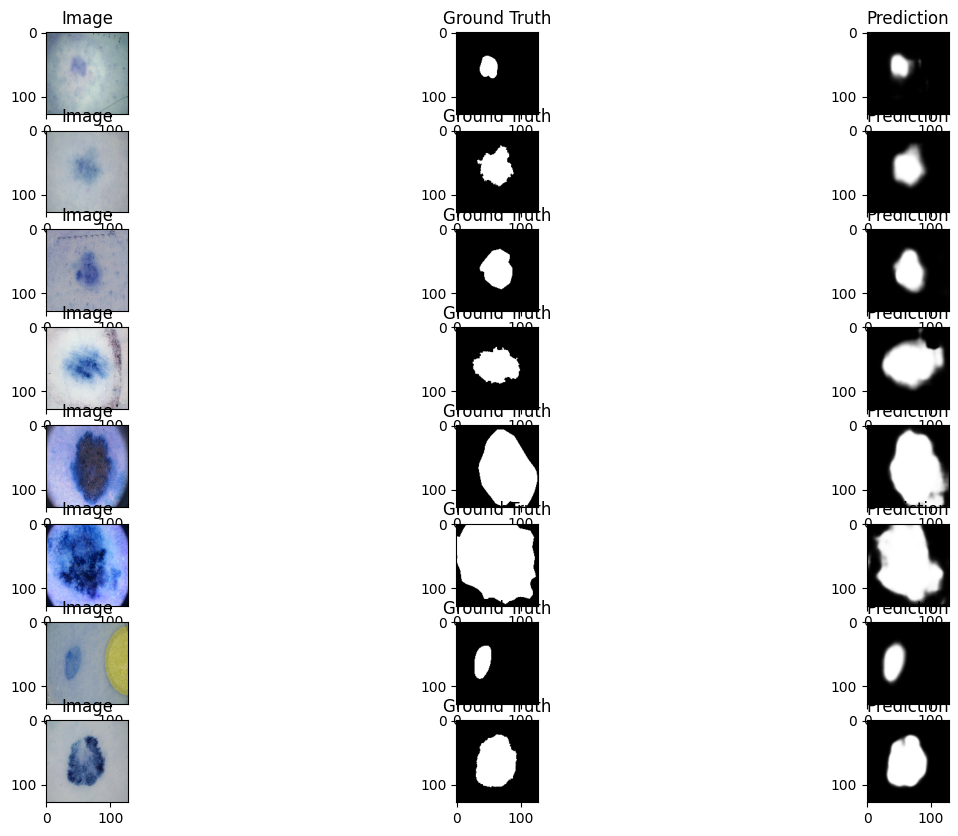

In [ ]:
# Visualize predictions
def display_predictions(images, masks, model, num_images=8):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(0, images.shape[0])
        image = images[idx]
        mask = masks[idx]
        prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]

        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth')

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(prediction, cmap='gray')
        plt.title('Prediction')
    plt.show()

display_predictions(test_images, test_masks, model)

Mounted at /content/drive
Preprocessing training images...
Training images shape: (900, 128, 128, 3)
Preprocessing training masks...
Training masks shape: (900, 128, 128, 1)
Preprocessing test images...
Test images shape: (379, 128, 128, 3)
Preprocessing test masks...
Test masks shape: (379, 128, 128, 1)
X_train shape: (720, 128, 128, 3)
X_val shape: (180, 128, 128, 3)
y_train shape: (720, 128, 128, 1)
y_val shape: (180, 128, 128, 1)
Building ResUNet model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 64)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 11,617,601 (44.32 MB)

 Trainable params: 11,611,969 (44.30 MB)

 Non-trainable params: 5,632 (22.00 KB)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8298 - dice_coef: 0.5803 - loss: 0.3918 - mean_io_u: 0.3657
Epoch 1: val_loss improved from inf to 0.66641, saving model to /content/drive/MyDrive/health_care_project/res_unet_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 399ms/step - accuracy: 0.8308 - dice_coef: 0.5823 - loss: 0.3899 - mean_io_u: 0.3657 - val_accuracy: 0.7416 - val_dice_coef: 0.1512 - val_loss: 0.6664 - val_mean_io_u: 0.3708
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9145 - dice_coef: 0.7830 - loss: 0.2132 - mean_io_u: 0.3655
Epoch 2: val_loss did not improve from 0.66641
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9146 - dice_coef: 0.7832 - loss: 0.2129 - mean_io_u: 0.3658 - val_accuracy: 0.7416 - val_dice_coef: 0.0800 - val_loss: 0.8374 - val_mean_io_u: 0.3708
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9313 - dice_coef: 0.8111 - loss: 0.1728 - mean_io_u: 0.4031
Epoch 3: val_loss did not improve from 0

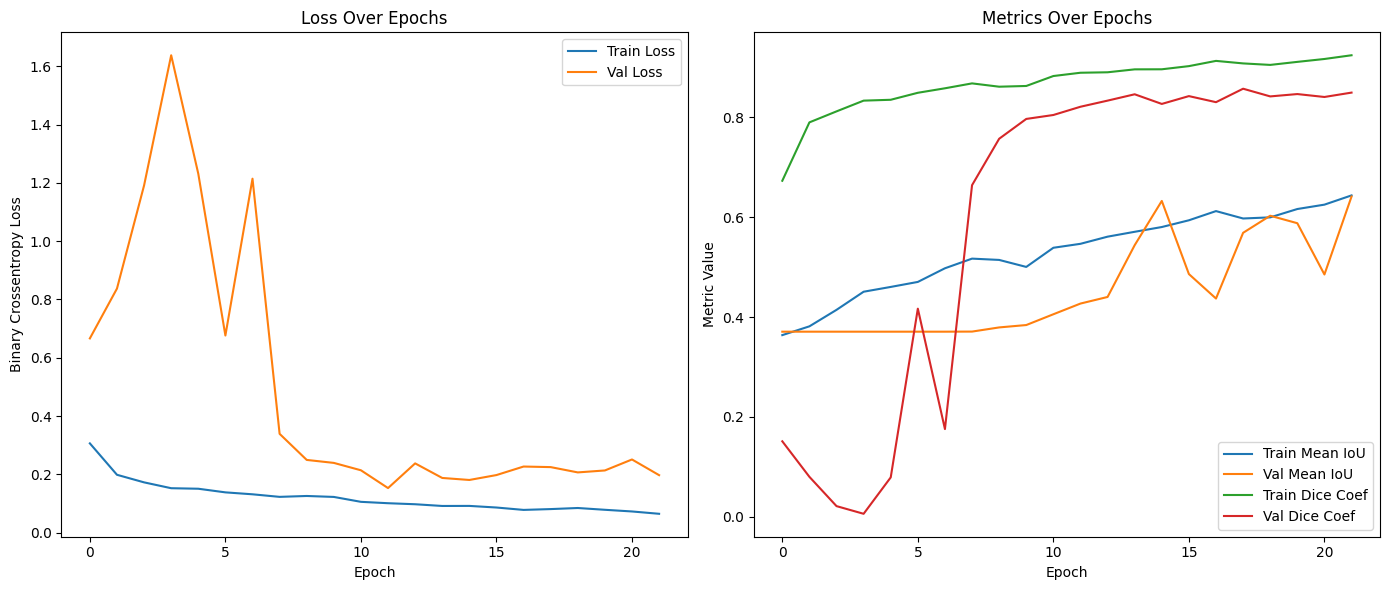

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


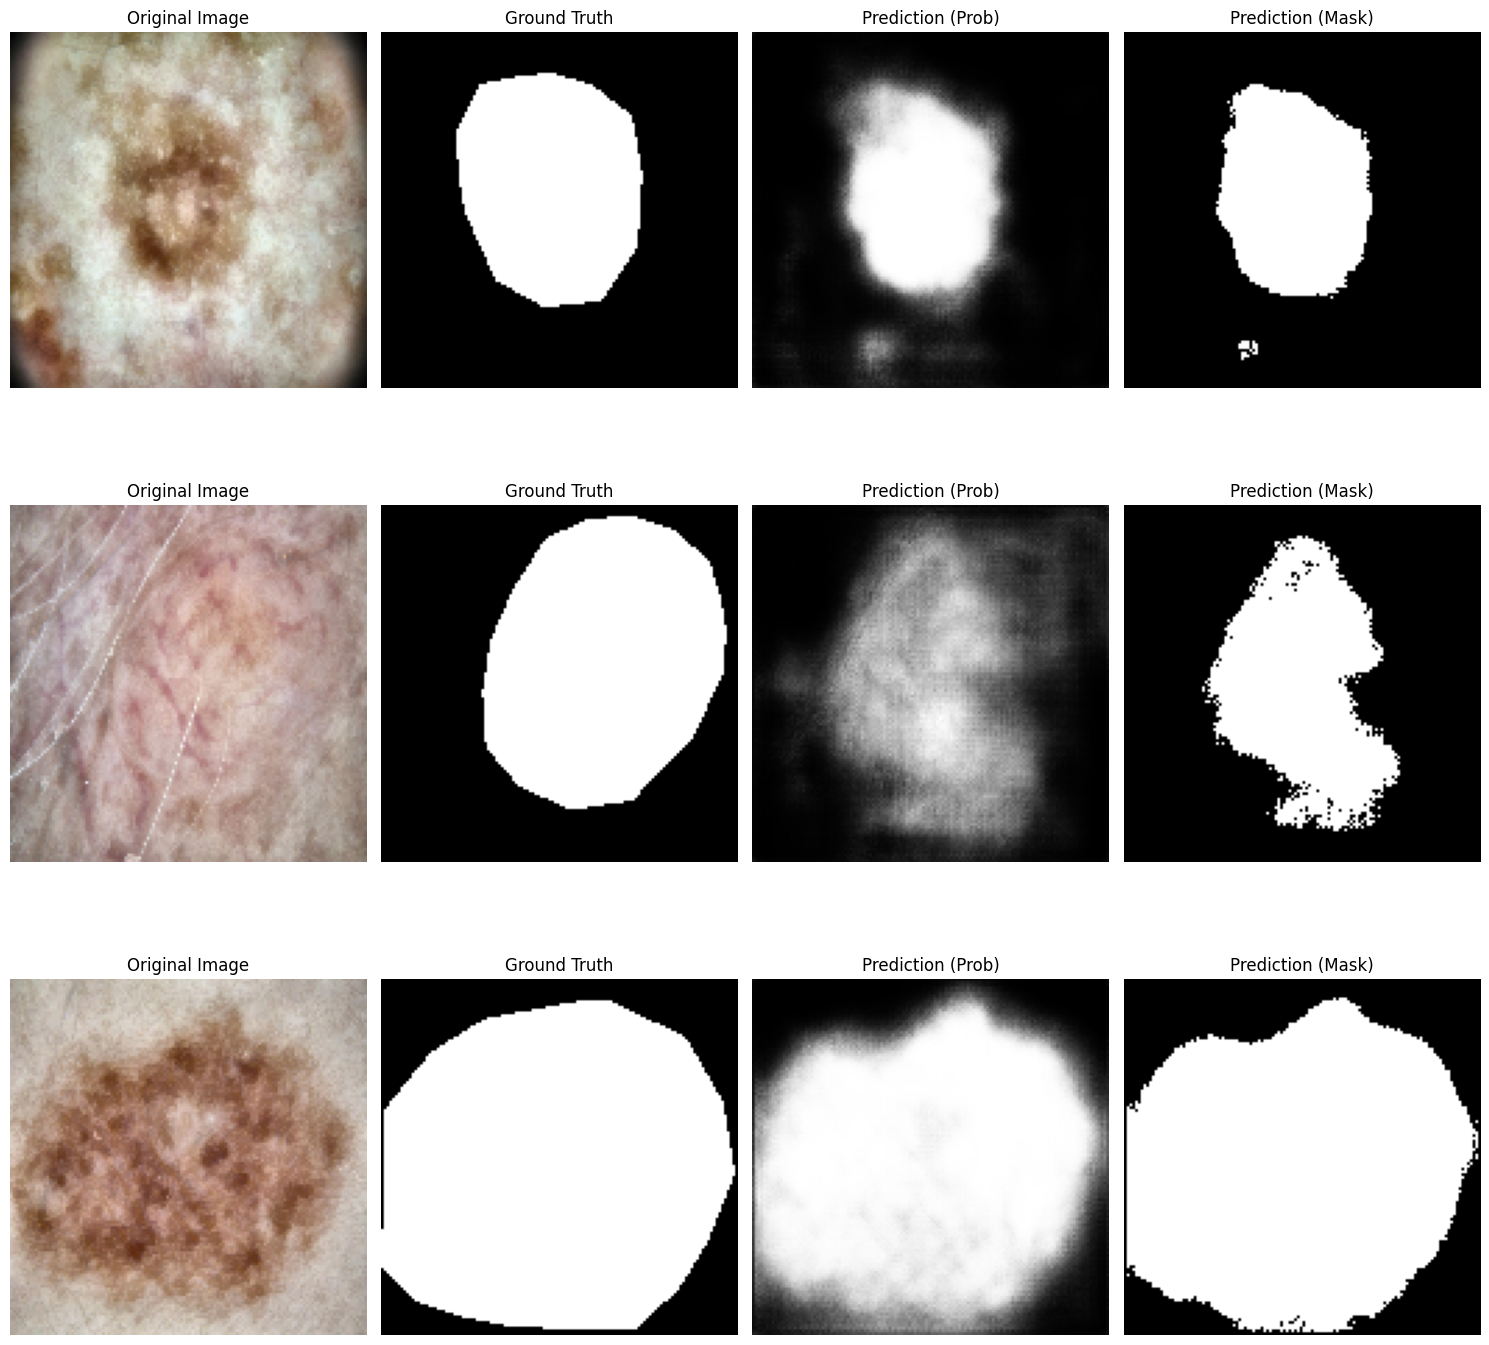

Sample image or mask not found. Please check the filenames and paths.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.mixed_precision import Policy
from google.colab import drive
import cv2

# Enable Mixed Precision
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
base_dir = '/content/drive/MyDrive/health_care_project/extracted_files'
train_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_Data')
train_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_GroundTruth')
test_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_Data')
test_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_GroundTruth')

# Preprocessing Functions

def preprocess_image(image, target_size=(128, 128)):
    """
    Preprocess a single image by applying hair removal, contrast enhancement,
    and resizing to a target size.
    """
    # Step 1: Convert to Grayscale for Hair Removal
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Step 2: Apply Morphological Operations to Detect Hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Step 3: Inpaint to Remove Hair
    _, binary_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpainted_image = cv2.inpaint(image, binary_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    # Step 4: Contrast Enhancement (CLAHE)
    lab = cv2.cvtColor(inpainted_image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # Step 5: Resize Image
    resized_image = cv2.resize(enhanced_image, target_size)

    # Step 6: Normalize Pixel Values to [0, 1]
    normalized_image = resized_image / 255.0

    return normalized_image


def preprocess_dataset(image_folder, target_size=(128, 128)):
    """
    Preprocess all images in a folder and return them as a NumPy array.
    """
    images = []
    filenames = sorted(os.listdir(image_folder))
    for filename in filenames:
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            preprocessed_img = preprocess_image(img, target_size=target_size)
            images.append(preprocessed_img)
    return np.array(images)


def preprocess_mask(mask, target_size=(128, 128)):
    """
    Preprocess a single binary mask:
    1. Resize the mask to the target size.
    2. Binarize the mask to ensure values are 0 or 1.
    3. Add a channel axis for compatibility with deep learning models.
    """
    # Step 1: Resize Mask
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Step 2: Binarize the Mask
    _, binarized_mask = cv2.threshold(resized_mask, 127, 1, cv2.THRESH_BINARY)

    # Step 3: Add a Channel Axis
    binarized_mask = np.expand_dims(binarized_mask, axis=-1)

    return binarized_mask


def preprocess_masks_from_folder(folder, target_size=(128, 128)):
    """
    Preprocess all masks in a folder and return them as a NumPy array.
    """
    masks = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        mask_path = os.path.join(folder, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            preprocessed_mask = preprocess_mask(mask, target_size=target_size)
            masks.append(preprocessed_mask)
    return np.array(masks)

# Load and Preprocess Images and Masks
print("Preprocessing training images...")
train_images = preprocess_dataset(train_images_dir, target_size=(128, 128))
print("Preprocessing training masks...")
train_masks = preprocess_masks_from_folder(train_masks_dir, target_size=(128, 128))
print("Preprocessing test images...")
test_images = preprocess_dataset(test_images_dir, target_size=(128, 128))
print("Preprocessing test masks...")
test_masks = preprocess_masks_from_folder(test_masks_dir, target_size=(128, 128))

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Define U-Net model
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u6 = layers.concatenate([u6, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

# Display Model Summary
model.summary()

# Training the model
checkpoint_path = '/content/drive/MyDrive/health_care_project/unet_model_v2.keras'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint]
)

# Load the best saved model
model = keras.models.load_model(checkpoint_path, compile=False)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

# Evaluate the model
test_loss, test_miou = model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}')
print(f'Test Mean IoU: {test_miou}')

# Visualize training history
def plot_history(history):
    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy Loss')
    plt.legend()

    # Plot Mean IoU
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_io_u'], label='Train Mean IoU')
    plt.plot(history.history['val_mean_io_u'], label='Val Mean IoU')
    plt.title('Mean IoU Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Visualize predictions
def display_predictions(images, masks, model, num_images=3):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(0, images.shape[0])
        image = images[idx]
        mask = masks[idx]
        prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
        prediction_thresholded = (prediction > 0.5).astype(np.float32)

        plt.subplot(num_images, 4, i*4 + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 3)
        plt.imshow(prediction, cmap='gray')
        plt.title('Prediction (Prob)')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 4)
        plt.imshow(prediction_thresholded, cmap='gray')
        plt.title('Prediction (Mask)')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(test_images, test_masks, model)

# Example: Visualizing Preprocessing for a Single Image and Mask
def visualize_preprocessing(sample_image_path, sample_mask_path):
    # Load and preprocess the sample image
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    preprocessed_sample = preprocess_image(sample_image)

    # Load and preprocess the sample mask
    mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)
    preprocessed_mask = preprocess_mask(mask)

    # Visualize Original and Preprocessed Image
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 2, 1)
    plt.imshow(sample_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(preprocessed_sample)
    plt.title('Preprocessed Image')
    plt.axis('off')

    # Visualize Original and Preprocessed Mask
    plt.subplot(2, 2, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(preprocessed_mask.squeeze(), cmap='gray')
    plt.title('Preprocessed Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Provide the paths to a sample image and mask
sample_image_path = os.path.join(train_images_dir, 'ISIC_0000100.jpg')  # Replace with your sample image filename
sample_mask_path = os.path.join(train_masks_dir, 'ISIC_0000100_segmentation.png')  # Replace with your sample mask filename

# Visualize the preprocessing steps for the sample image and mask
visualize_preprocessing(sample_image_path, sample_mask_path)
